# Electricity prices EDA

In [6]:
import os
print(f'Current working dir:\t {os.getcwd()}')
from pathlib import Path

from datetime import datetime
# from datetime import timedelta

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib widget

Current working dir:	 c:\GitRepos\various-data-analysis\electricity-prices


In [13]:
filename = Path("Rocni_zprava_o_trhu_2022_V0_rijen.csv")
root_data = Path("C:/DATA_FAST/electricity")
# read only header first for prep on parsing and stuff
cols_from_header = pd.read_csv(root_data / filename, nrows=0).columns.tolist()
# # parse_dates = ['begins_at', 'ends_at', 'created_at', 'updated_at', 'expired_at', 'paid_at']
# # data_raw = pd.read_csv(filename, index_col='id', parse_dates=parse_dates).drop(columns=['payment_id'])
data_raw = pd.read_csv(root_data / filename, parse_dates=['Den']) #.drop(columns=['payment_id'])
data_raw = data_raw.dropna()
data_raw


,Den,Hodina,CZK/MWh
0,2022-01-01,1,1244.24
1,2022-01-01,2,1027.46
2,2022-01-01,3,1074.45
3,2022-01-01,4,1130.14
4,2022-01-01,5,936.48
...,...,...,...
7194,2022-10-27,20,4088.42
7195,2022-10-27,21,3686.86
7196,2022-10-27,22,3368.46
7197,2022-10-27,23,3334.61


In [28]:
df = pd.DataFrame()
df['day'] = pd.to_datetime(data_raw['Den'])
df['date'] = pd.to_datetime(data_raw['Den'])
df['date'] += pd.to_timedelta(data_raw['Hodina'], unit='h')
df['month'] = data_raw['Den'].apply(lambda date: date.month)
df['hour'] = data_raw['Hodina']
df['price'] = data_raw['CZK/MWh']
df.set_index('date')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7199 entries, 0 to 7198
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   day     7199 non-null   datetime64[ns]
 1   date    7199 non-null   datetime64[ns]
 2   month   7199 non-null   int64         
 3   hour    7199 non-null   int64         
 4   price   7199 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 281.3 KB


,month,hour,price
count,7199.000000,7199.000000,7199.000000
mean,5.467009,12.498403,6252.877996
std,2.843171,6.921821,3423.226721
min,1.000000,1.000000,0.000000
25%,3.000000,6.500000,3974.040000
50%,5.000000,12.000000,5361.620000
75%,8.000000,18.000000,8117.365000
max,10.000000,24.000000,21422.250000


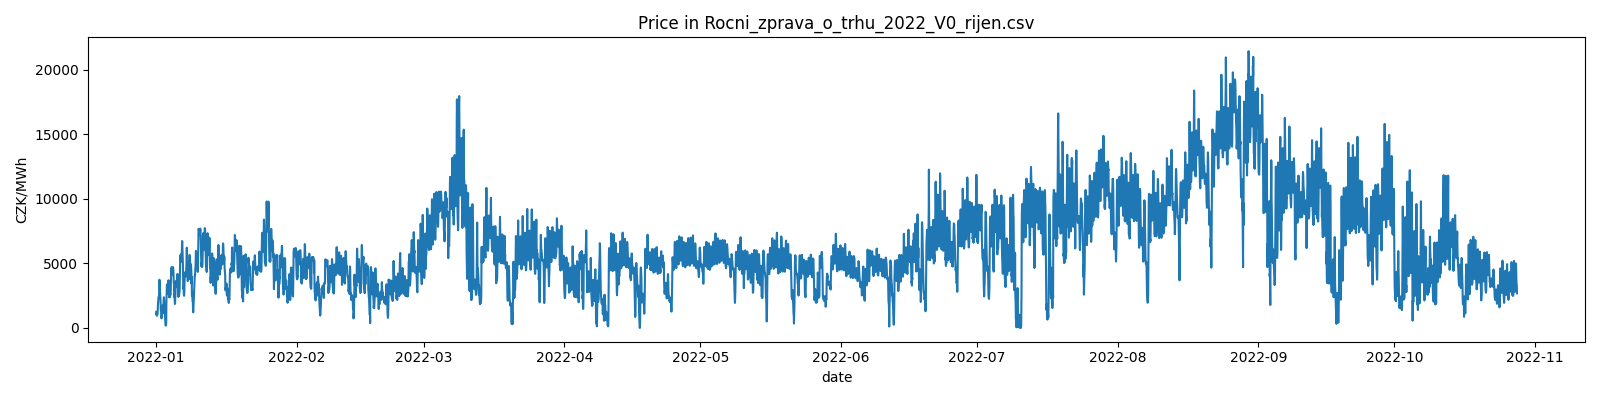

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.lineplot(data=df, x='date', y='price')
ax.set_title(f'Price in {filename}')
ax.set_ylabel('CZK/MWh')
fig.tight_layout()

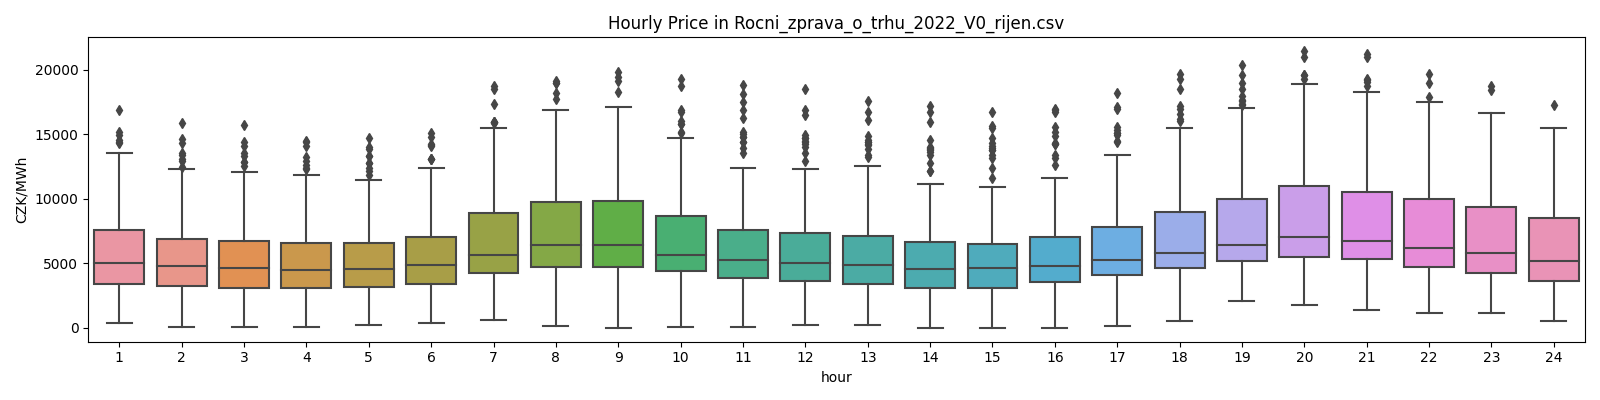

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.boxplot(data=df, x='hour', y='price')
ax.set_title(f'Hourly Price in {filename}')
ax.set_ylabel('CZK/MWh')
fig.tight_layout()

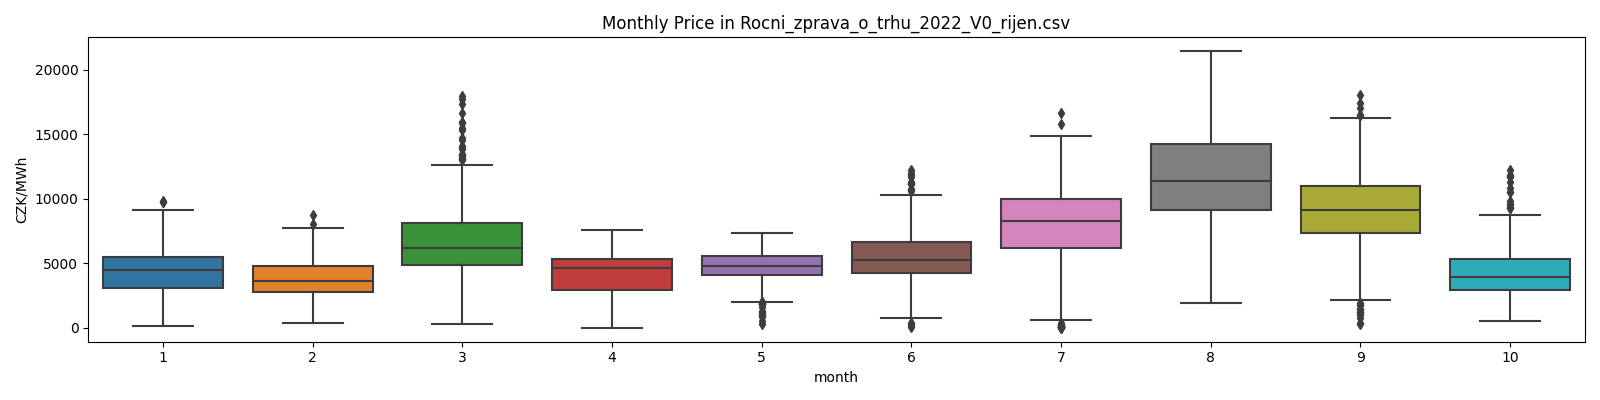

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.boxplot(data=df, x='month', y='price')
ax.set_title(f'Monthly Price in {filename}')
ax.set_ylabel('CZK/MWh')
fig.tight_layout()

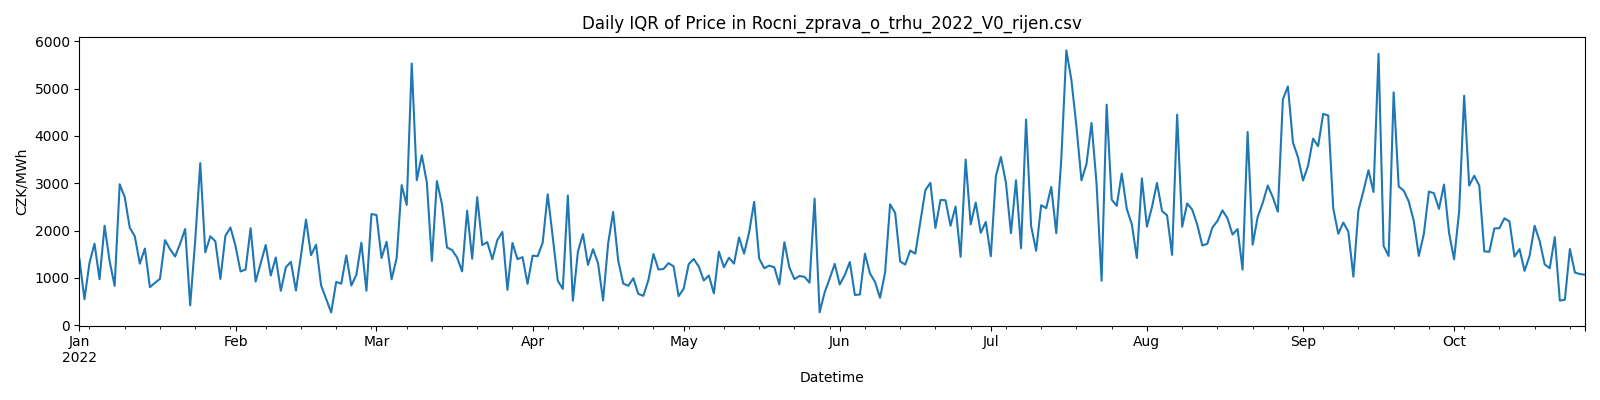

In [117]:
df_daily = df.groupby(by='day')
intraday_price = df_daily.apply(lambda x: x['price'].quantile(0.75) - x['price'].quantile(0.25))
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
intraday_price.plot(ax=ax)
ax.set_title(f'Daily IQR of Price in {filename}')
ax.set_xlabel('Datetime')
ax.set_ylabel('CZK/MWh')
fig.tight_layout()

In [118]:
intraday_price.describe()

count     300.000000
mean     1959.139783
std      1029.326243
min       271.330000
25%      1242.903125
50%      1725.845000
75%      2514.060000
max      5807.842500
dtype: float64

In [32]:
capacity = 12.6 * 0.8  # kWh
pricedif = 0.7  # CZK/kWh
repeatsperday = 2

equipment_price = 172000 - 126000  # CZK
breakeven_days = equipment_price/(capacity * pricedif * repeatsperday)
print(f'Breakeven in {breakeven_days/365:.1f} years')

Breakeven in 8.9 years


# Price of Battery






In [144]:
base_cost = 26862 + 10000  # CZK
num_modules = 3
module_cost = 44044 # CZK
equipment_cost = base_cost + num_modules*module_cost
print(f'Total cost for {num_modules} modules with base is {equipment_cost} CZK')

n_lifetimes = 1
n_cycles = n_lifetimes * 6000
# mean capacity factor for the guaranteed cycles
# usually 80 % after cycles remains => 90 % deprecation factor
deprecation_factor = 1 - n_lifetimes*0.1
round_trip_efficiency = 0.9
dod = 0.9  # Depth of Discharge

nominal_capacity = 3.55  # kWh
battery_capacity = num_modules * nominal_capacity * deprecation_factor
dod_usable_capacity = dod*battery_capacity
print(f'Battery capacity: {battery_capacity} kWh')
print(f'Battery capacity DOD80%: {dod_usable_capacity} kWh')

lifetime_energy_stored = n_cycles * dod_usable_capacity
print(f'Lifetime energy stored: {lifetime_energy_stored} kWh')

kwh_storage_price = equipment_cost / lifetime_energy_stored
print(f'Price of kWh stored: {kwh_storage_price} CZK/kWh')



Total cost for 3 modules with base is 168994 CZK
Battery capacity: 9.584999999999999 kWh
Battery capacity DOD80%: 8.6265 kWh
Lifetime energy stored: 51759.0 kWh
Price of kWh stored: 3.2650167120693987 CZK/kWh


In [129]:
df_daily = df.groupby(by='day')
intraday_pricedif = df_daily.apply(lambda x: round_trip_efficiency*x['price'].quantile(.75) - x['price'].min())
intraday_pricedif.describe()

count     300.000000
mean     2237.054895
std      1315.809798
min       224.154250
25%      1316.430438
50%      1956.463875
75%      2847.944688
max      8301.054500
dtype: float64

In [135]:
yearly_consumption = 11000  # kWh

years_of_service = lifetime_energy_stored/ (yearly_consumption/2)
print(f'Estimated years of service: {years_of_service}')

Estimated years of service: 14.072522727272721
